<a href="https://colab.research.google.com/github/trhgquan/OCR_chu_nom/blob/main/do_an_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR chữ Nôm, nhưng nó lạ lắm

Based on [Kuzushiji Recognition just like Digit Recognition](https://www.kaggle.com/basu369victor/kuzushiji-recognition-just-like-digit-recognition/notebook)

13/11/2021: Tạm train thành công model_chu_nom.h5 (xem trong Google Drive). Cách xài như ở cell cuối cùng.

Có thời gian tôi sẽ train lại + áp thêm kĩ thuật generate hình để model predict đỉnh hơn.

Tham khảo các tài liệu sau:
- [Kuzushiji Recognition just like Digit Recognition](https://www.kaggle.com/basu369victor/kuzushiji-recognition-just-like-digit-recognition/notebook)
- [Xử lí tràn bộ nhớ bằng cách chia nhỏ dataset](https://www.miai.vn/2020/10/27/flow-from-directory-thuoc-dac-tri-het-ram-tran-bo-nho-khi-train-model)

Một số thứ **không nên** làm:
- Crop ảnh ra thành file (tốn thời gian)
- Download ảnh về, extract ra xong tải lên lại (tốn thời gian x2)
- Chạy notebook trên local (tốn RAM, riêng tôi bị crash máy)

Một số vấn đề **đang** xảy ra:
- Tần số chữ xuất hiện quá nhiều -> Số lượng chữ crop ra rất nhiều, tràn RAM.
Xử lí bằng link 2 bên trên.

# Chuẩn bị + xử lý data đầu vào

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization,Input
from keras.models import Model,load_model
from IPython.display import SVG
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import zipfile
import gc
%matplotlib inline

In [ ]:
# Unzip file data_real.zip trong google drive
def extract_data_real():
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/data_real.zip')  as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom')

In [ ]:
FONT_PATH = '/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/NotoSansCJKjp-Regular.otf'
UNICODE_TRANSLATE_PATH = '/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/unicode_translate.csv'
TRAINING_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/train.csv'
IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/data_real/img/{}'

In [ ]:
fontsize = 50

font = ImageFont.truetype(FONT_PATH, fontsize, encoding = 'utf-8')

In [ ]:
df_train = pd.read_csv(TRAINING_CSV_PATH)
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(UNICODE_TRANSLATE_PATH).values}

In [ ]:
df_train.isnull().sum()

image_id    0
labels      0
dtype: int64

In [ ]:
# Return the image containing the bounding boxes and characters annotated
def visualise_training_data(image_fn, labels):
    # Remove last space accidentally created during generation.
    labels = np.array(labels.split(' '))[:-1].reshape(-1, 5)
    
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas)
    char_draw = ImageDraw.Draw(char_canvas)
    
    for label, x1, y1, x2, y2 in labels:
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        h, w = abs(x1 - x2), abs(y1 - y2)
        
        char = unicode_map[label]
        
        bbox_draw.rectangle((x1, y1, x2, y2), fill = (255, 255, 255, 0), outline = (255, 0, 0, 255))
        char_draw.text((x1 + w + fontsize / 4, y1 + h/2 - fontsize), char, fill = (0, 0, 255, 255), font = font)
        
        cropped_image = imsource.crop((x1, y1, x2, y2))
        plt.figure()
        print(char)
        plt.imshow(cropped_image)
        plt.show()
    
    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert('RGB')
    
    return np.asarray(imsource)

In [ ]:
np.random.seed(1337)

def show_random_train_image():
    for i in range(1):
        img, labels = df_train.values[np.random.randint(len(df_train))]
        visualise = visualise_training_data(IMAGE_PATH.format(img), labels)
      
        plt.figure(figsize = (15, 15))
        plt.title(img)
        plt.imshow(visualise, interpolation = 'lanczos')
        plt.show()

# show_random_train_image()

In [ ]:
def ExtractData(limited_size = 420):
    X_, Y_ = [], []
    
    for img, labels in tqdm(df_train[0:limited_size].values):
        try:
            image_fn = IMAGE_PATH.format(img)
            labels = np.array(labels.split(' '))[:-1].reshape(-1, 5)
    
            imsource = Image.open(image_fn).convert('RGBA')
            bbox_canvas = Image.new('RGBA', imsource.size)
            char_canvas = Image.new('RGBA', imsource.size)
            bbox_draw = ImageDraw.Draw(bbox_canvas)
            char_draw = ImageDraw.Draw(char_canvas)

            for label, x1, y1, x2, y2 in labels:
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                h, w = abs(x1 - x2), abs(y1 - y2)

                char = unicode_map[label]

                cropped_image = imsource.crop((x1, y1, x2, y2))
                image = cropped_image.resize((300, 300))
                image = np.asarray(image)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                ret, th1 = cv2.threshold(image, 155, 255, cv2.THRESH_BINARY_INV)

                X_.append(th1)
                Y_.append(str(char))
                
        except:
            pass

    X_ = np.array(X_)
    Y_ = np.array(Y_)

    return X_, Y_

In [ ]:
# XX_, yy_ = ExtractData(50)

XX_ = np.load('XX_.npy')
yy_ = np.load('yy_.npy')

In [ ]:
XX_.shape

(16311, 300, 300)

In [ ]:
# Save de load nhanh hon, khong can extract
np.save('XX_.npy', XX_)
np.save('yy_.npy', yy_)

In [ ]:
unique, counts = np.unique(yy_, return_counts = True)
print(unique, counts)

NumberOfClasses = len(unique)
NumberOfClasses

['#' '㑹' '㓜' ... '𨐫' '𨚗' '𫝹'] [20  8  1 ...  1 14  5]


1144

In [ ]:
IMG_ROWS = 300
IMG_COLS = 300

def preprocessData(X, y):
  lb = LabelEncoder()
  y_integer = lb.fit_transform(y)
  out_y = np_utils.to_categorical(y_integer)
  num_images = X.shape[0]
  out_x = X.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
  return out_x, out_y

In [ ]:
lb = LabelEncoder()
y_integer = lb.fit_transform(yy_)

In [ ]:
# Chia dataset ra lam train va test.

X, y = preprocessData(XX_, yy_)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [ ]:
# Augment dataset to increase accuracy
aug = ImageDataGenerator(zoom_range = [0.5, 2.0])

# Train model

In [ ]:
K.clear_session()

def chu_nom_classifier(in_):
    model_ = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(in_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(32, (3, 3), activation = 'relu')(model_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(32, 5, strides = 2, padding = 'same', activation = 'relu')(model_)
    model_ = MaxPooling2D((2, 2))(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(0.4)(model_)
    model_ = Conv2D(64, (3, 3), strides = 2, padding = 'same', activation = 'relu')(model_)
    model_ = MaxPooling2D(pool_size = (2, 2))(model_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'relu')(model_)
    model_ = Dropout(0.4)(model_)
    model_ = Flatten()(model_)
    model_ = Dense(128, activation = 'relu')(model_)
    model_ = Dense(NumberOfClasses, activation = 'softmax')(model_)

    return model_

In [ ]:
Input_Sample = Input(shape = (300, 300, 1))
Output_ = chu_nom_classifier(Input_Sample)
Model_Enhancer = Model(inputs = Input_Sample, outputs = Output_)

In [ ]:
Model_Enhancer.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model_Enhancer.summary()

In [ ]:
tf.test.gpu_device_name()

In [ ]:
checkpointer = ModelCheckpoint('model_chu_nom.h5', 
                               verbose = 1, 
                               mode = 'auto', 
                               monitor = 'val_loss', 
                               save_best_only = True)

# Data generator goes here.

ModelHistory = Model_Enhancer.fit(aug.flow(X_train, y_train, batch_size = 50),
                                  epochs = 10,
                                  verbose = 1,
                                  callbacks = [checkpointer],
                                  validation_data = (X_val, y_val))

In [ ]:
#Loss Curves

plt.figure(figsize=[20,9])
plt.plot(ModelHistory.history['loss'], 'r')
plt.plot(ModelHistory.history['val_loss'], 'b')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

In [ ]:
#Accuracy Curves
plt.figure(figsize=[20,9])
plt.plot(ModelHistory.history['accuracy'], 'r')
plt.plot(ModelHistory.history['val_accuracy'], 'b')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

# Predict + visualise

In [ ]:
# Model_ = load_model('model_chu_nom.h5')
# Model_.summary()

Model_ = load_model('/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/model_chu_nom.h5')
Model_.summary()

yy_ = np.load('/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/yy_.npy')
lb = LabelEncoder()
y_integer = lb.fit_transform(yy_)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 298, 298, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 298, 298, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 149, 149, 32)      25632 

In [ ]:
def predict_chu_nom(imagePath):
    img = cv2.imread(imagePath)

    imsource = Image.open(imagePath)#fromarray(img)
    imsource = imsource.convert('RGB')

    char_draw = ImageDraw.Draw(imsource)
    im_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, im_th = cv2.threshold(im_grey, 130, 255, cv2.THRESH_BINARY_INV)

    # ret, im_th = cv2.threshold(im_grey, 255, 255, cv2.THRESH_BINARY_INV)
    ctrs,_ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    print(rects)
    ChuNoms = []
    for rect in rects:
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

        if roi.size > 7000:
            cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (225, 0, 0), 6)
            roi = cv2.resize(roi, (300,300))
            
            ret,th1 = cv2.threshold(roi, 155, 255, cv2.THRESH_BINARY)

            ProcessImage = th1.reshape(1, IMG_ROWS, IMG_COLS, 1)
            y_pred = Model_.predict(ProcessImage)
            y_true = np.argmax(y_pred, axis=1)
            ChuNom = lb.inverse_transform(y_true)

            ChuNoms.append(str(ChuNom[0]))

            char_draw.text((rect[0] + 80, rect[1]), str(ChuNom[0]), fill=(0, 22, 225, 0), font=font)
            # char_draw.text((rect[0] + 80, rect[1]), str(ChuNom[0]), fill=(0), font=font)

    return img,imsource,ChuNoms

OCR-ed data:
[(1247, 2634, 56, 82), (1250, 2562, 51, 11), (1259, 2532, 33, 11), (1255, 2505, 40, 12), (1247, 2361, 54, 85), (1253, 1717, 6, 19), (1261, 1715, 5, 15), (1267, 1712, 6, 15), (1269, 1707, 33, 32), (1289, 1673, 10, 32), (1271, 1665, 29, 43), (1254, 1659, 18, 53), (1254, 1571, 43, 82), (1252, 1485, 49, 79), (818, 1463, 1, 1), (1265, 1455, 5, 15), (726, 1455, 4, 2), (1270, 1453, 7, 16), (690, 1444, 2, 3), (1093, 1432, 18, 24), (1172, 1427, 1, 1), (500, 1421, 7, 9), (1094, 1419, 13, 8), (1042, 1418, 16, 22), (1111, 1413, 17, 24), (1096, 1409, 12, 8), (412, 1408, 9, 39), (921, 1402, 20, 44), (861, 1400, 19, 25), (1112, 1399, 34, 59), (941, 1399, 35, 57), (1257, 1396, 47, 83), (999, 1396, 35, 49), (828, 1392, 8, 10), (302, 1391, 24, 46), (1082, 1390, 32, 23), (950, 1385, 9, 15), (923, 1385, 17, 10), (823, 1385, 63, 65), (1004, 1384, 46, 17), (736, 1382, 61, 67), (574, 1379, 46, 66), (549, 1379, 24, 65), (308, 1378, 14, 10), (472, 1377, 60, 68), (644, 1376, 53, 72), (381, 1376, 65

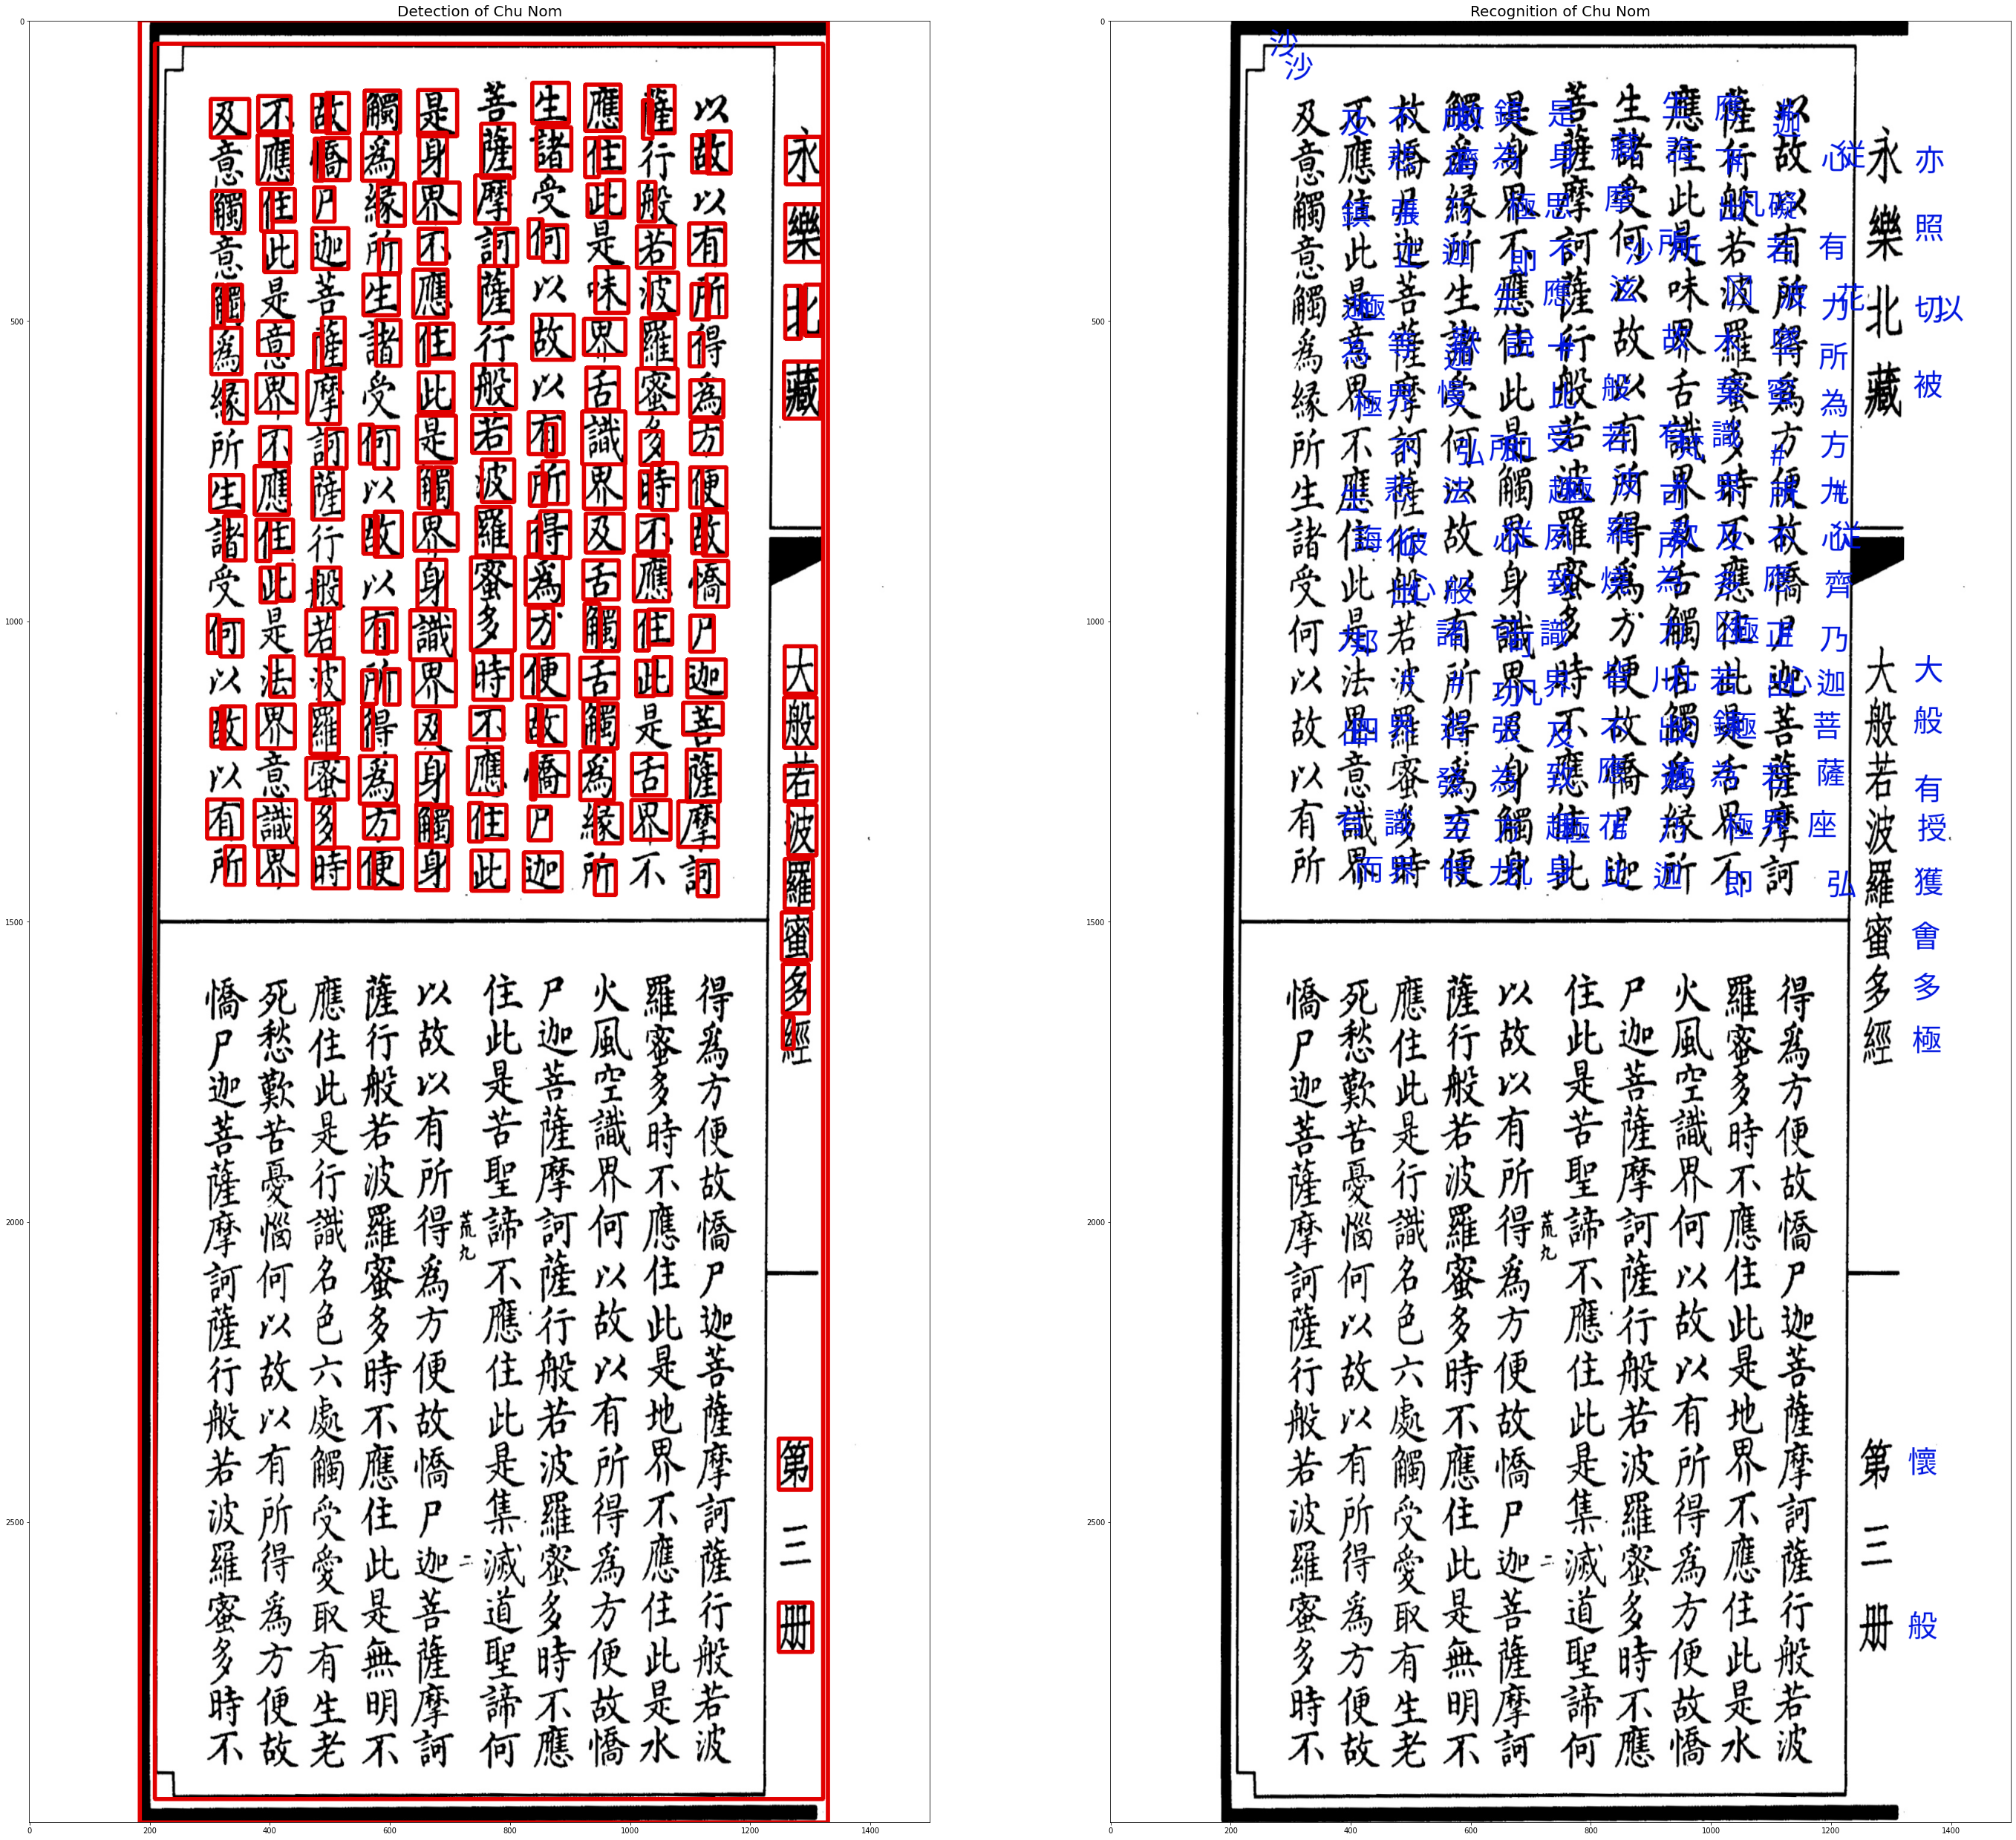

In [ ]:
print("OCR-ed data:")

img1, imsource1, predicted = predict_chu_nom('/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/data_real/img/122.jpg')

plt.figure(figsize=(100,100))
plt.subplot(1,4,1)
plt.title("Detection of Chu Nom",fontsize=20)
plt.imshow(img1)
plt.subplot(1,4,2)
plt.title("Recognition of Chu Nom",fontsize=20)
plt.imshow(imsource1)

for c in predicted:
  print(c, end = '')

In [ ]:
!cp "model_chu_nom.h5" "/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/model_chu_nom.h5"
!cp "XX_.npy" "/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/XX_.npy"
!cp "yy_.npy" "/content/drive/MyDrive/Colab Notebooks/do_an_chu_Nom/yy_.npy"